# TEAM CHALLENGE **PIPELINES**: **PROBLEMA DE REGRESIÓN**

## Problema de negocio y tareas

**Problema de regresión**: Predecir cuántas kcal tiene un alimento dependiendo de unas variables

## Importación de módulos

In [24]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import toolbox_ML as tb
import pickle
import warnings
warnings.filterwarnings('ignore')

from pandas.api.types import is_numeric_dtype

from sklearn.compose import ColumnTransformer, make_column_selector, TransformedTargetRegressor
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, MinMaxScaler

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

## Carga de datos y primera visualización

In [2]:
df = pd.read_csv('./data/nutrition.csv')
df.head()

,ID,FoodGroup,ShortDescrip,Descrip,CommonName,MfgName,ScientificName,Energy_kcal,Protein_g,Fat_g,...,Folate_USRDA,Niacin_USRDA,Riboflavin_USRDA,Thiamin_USRDA,Calcium_USRDA,Copper_USRDA,Magnesium_USRDA,Phosphorus_USRDA,Selenium_USRDA,Zinc_USRDA
0,1001,Dairy and Egg Products,"BUTTER,WITH SALT","Butter, salted",NaN,NaN,NaN,717.0,0.85,81.11,...,0.0075,0.002625,0.026154,0.004167,0.020000,0.000000,0.004762,0.034286,0.018182,0.008182
1,1002,Dairy and Egg Products,"BUTTER,WHIPPED,WITH SALT","Butter, whipped, with salt",NaN,NaN,NaN,717.0,0.85,81.11,...,0.0075,0.002625,0.026154,0.004167,0.020000,0.000018,0.004762,0.032857,0.018182,0.004545
2,1003,Dairy and Egg Products,"BUTTER OIL,ANHYDROUS","Butter oil, anhydrous",NaN,NaN,NaN,876.0,0.28,99.48,...,0.0000,0.000188,0.003846,0.000833,0.003333,0.000001,0.000000,0.004286,0.000000,0.000909
3,1004,Dairy and Egg Products,"CHEESE,BLUE","Cheese, blue",NaN,NaN,NaN,353.0,21.40,28.74,...,0.0900,0.063500,0.293846,0.024167,0.440000,0.000044,0.054762,0.552857,0.263636,0.241818
4,1005,Dairy and Egg Products,"CHEESE,BRICK","Cheese, brick",NaN,NaN,NaN,371.0,23.24,29.68,...,0.0500,0.007375,0.270000,0.011667,0.561667,0.000027,0.057143,0.644286,0.263636,0.236364


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8618 entries, 0 to 8617
Data columns (total 45 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                8618 non-null   int64  
 1   FoodGroup         8618 non-null   object 
 2   ShortDescrip      8618 non-null   object 
 3   Descrip           8618 non-null   object 
 4   CommonName        1063 non-null   object 
 5   MfgName           1560 non-null   object 
 6   ScientificName    732 non-null    object 
 7   Energy_kcal       8618 non-null   float64
 8   Protein_g         8618 non-null   float64
 9   Fat_g             8618 non-null   float64
 10  Carb_g            8618 non-null   float64
 11  Sugar_g           8618 non-null   float64
 12  Fiber_g           8618 non-null   float64
 13  VitA_mcg          8618 non-null   float64
 14  VitB6_mg          8618 non-null   float64
 15  VitB12_mcg        8618 non-null   float64
 16  VitC_mg           8618 non-null   float64


Hay nulos en 3 columnas: **CommonName, MfgName** y **ScientificName**.  
Voy a mostrar el porcentaje de nulos con nuestra función del ToolBox.

In [4]:
var_nulos = 'CommonName', 'MfgName', 'ScientificName'
tb.describe_df(df[['CommonName', 'MfgName', 'ScientificName']])

,COL_N,CommonName,MfgName,ScientificName
0,DATA_TYPE,object,object,object
1,MISSINGS (%),87.665352,81.898352,91.50615
2,UNIQUE_VALUES,444,93,470
3,CARDIN (%),5.14,1.07,5.44


Cuando hagamos el split de **Train** y **Test** las eliminamos ya que es muy alto el porcentaje de nulos.  
Por lo demás, es una variable con bastantes columnas por de tipo numérica, la gran mayoría, y alguna de tipo 'object'.

## Separación de Train y Test

In [3]:
train_rg, test_rg = train_test_split(df, test_size=0.2, random_state=42)

In [6]:
print('Longitud de Train -->', len(train_rg))
print('Longitud de Test -->', len(test_rg))

Longitud de Train --> 6894
Longitud de Test --> 1724


## MiniEda

### Creación del Target y visualización de su distribución

In [4]:
target = 'Energy_kcal'

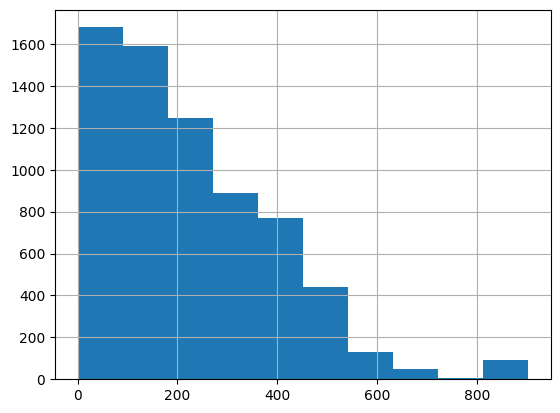

In [8]:
train_rg[target].hist();

*Nos encontramos con que la distribución del **Target** no tiene una distribuciín gaussiana por lo que, a la hora del entrenamiento, deberíamos realizar una transformación logarítmica para poder predecir mejor los resultados.*

In [9]:
train_rg[target].describe()

count    6894.000000
mean      227.318393
std       169.258228
min         0.000000
25%        94.000000
50%       192.000000
75%       337.000000
max       902.000000
Name: Energy_kcal, dtype: float64

In [10]:
tb.describe_df(train_rg[[target]])

,COL_N,Energy_kcal
0,DATA_TYPE,float64
1,MISSINGS (%),0.0
2,UNIQUE_VALUES,658
3,CARDIN (%),9.54


*Con estas informaciones, podemos ver que no hay una cardinalidad exagerada pero podemos ver que puede haber algún outlier*

### Tratamiento de columnas categóricas


En primer lugar vemos como son estas columnas

In [5]:
# Meto en una lista unicamente las variables que son de tipo object
var_cat = [col for col in train_rg.columns if df[col].dtype == 'object']
var_cat

['FoodGroup',
 'ShortDescrip',
 'Descrip',
 'CommonName',
 'MfgName',
 'ScientificName']

In [12]:
tb.describe_df(train_rg[var_cat])

,COL_N,FoodGroup,ShortDescrip,Descrip,CommonName,MfgName,ScientificName
0,DATA_TYPE,object,object,object,object,object,object
1,MISSINGS (%),0.0,0.0,0.0,87.510879,81.882797,91.340296
2,UNIQUE_VALUES,25,6891,6894,404,87,401
3,CARDIN (%),0.36,99.96,100.0,5.85,1.25,5.8


- Tenemos columnas categóricas con un elevado número de missings, como comentamos antes: `CommonName`, `MfgName`, `ScientificName`.
- Y columnas cuya cardinalidad es muy elevada: `ShortDescrip`, `Descrip`.

Excluiremos este listado de columnas ya que no tenemos datos suficientes como para tapar el elevado número de missings y por otro lado, las que presentan alta cardinalidad no aportarán mucha información relevante al modelo.

In [6]:
cat_columns_to_exclude = ['ShortDescrip','Descrip', 'CommonName', 'MfgName', 'ScientificName'] 

# Variable categórica que voy a transformar
cat_transform = ['FoodGroup']

### Tratamiento de columnas numéricas

Vemos la distribución de las columnas numéricas y su correlación

In [7]:
# Meto todas las variables numericas excluyendo el traget
var_num = [col for col in train_rg.columns if col != target and is_numeric_dtype(train_rg[col])]
var_num

['ID',
 'Protein_g',
 'Fat_g',
 'Carb_g',
 'Sugar_g',
 'Fiber_g',
 'VitA_mcg',
 'VitB6_mg',
 'VitB12_mcg',
 'VitC_mg',
 'VitE_mg',
 'Folate_mcg',
 'Niacin_mg',
 'Riboflavin_mg',
 'Thiamin_mg',
 'Calcium_mg',
 'Copper_mcg',
 'Iron_mg',
 'Magnesium_mg',
 'Manganese_mg',
 'Phosphorus_mg',
 'Selenium_mcg',
 'Zinc_mg',
 'VitA_USRDA',
 'VitB6_USRDA',
 'VitB12_USRDA',
 'VitC_USRDA',
 'VitE_USRDA',
 'Folate_USRDA',
 'Niacin_USRDA',
 'Riboflavin_USRDA',
 'Thiamin_USRDA',
 'Calcium_USRDA',
 'Copper_USRDA',
 'Magnesium_USRDA',
 'Phosphorus_USRDA',
 'Selenium_USRDA',
 'Zinc_USRDA']

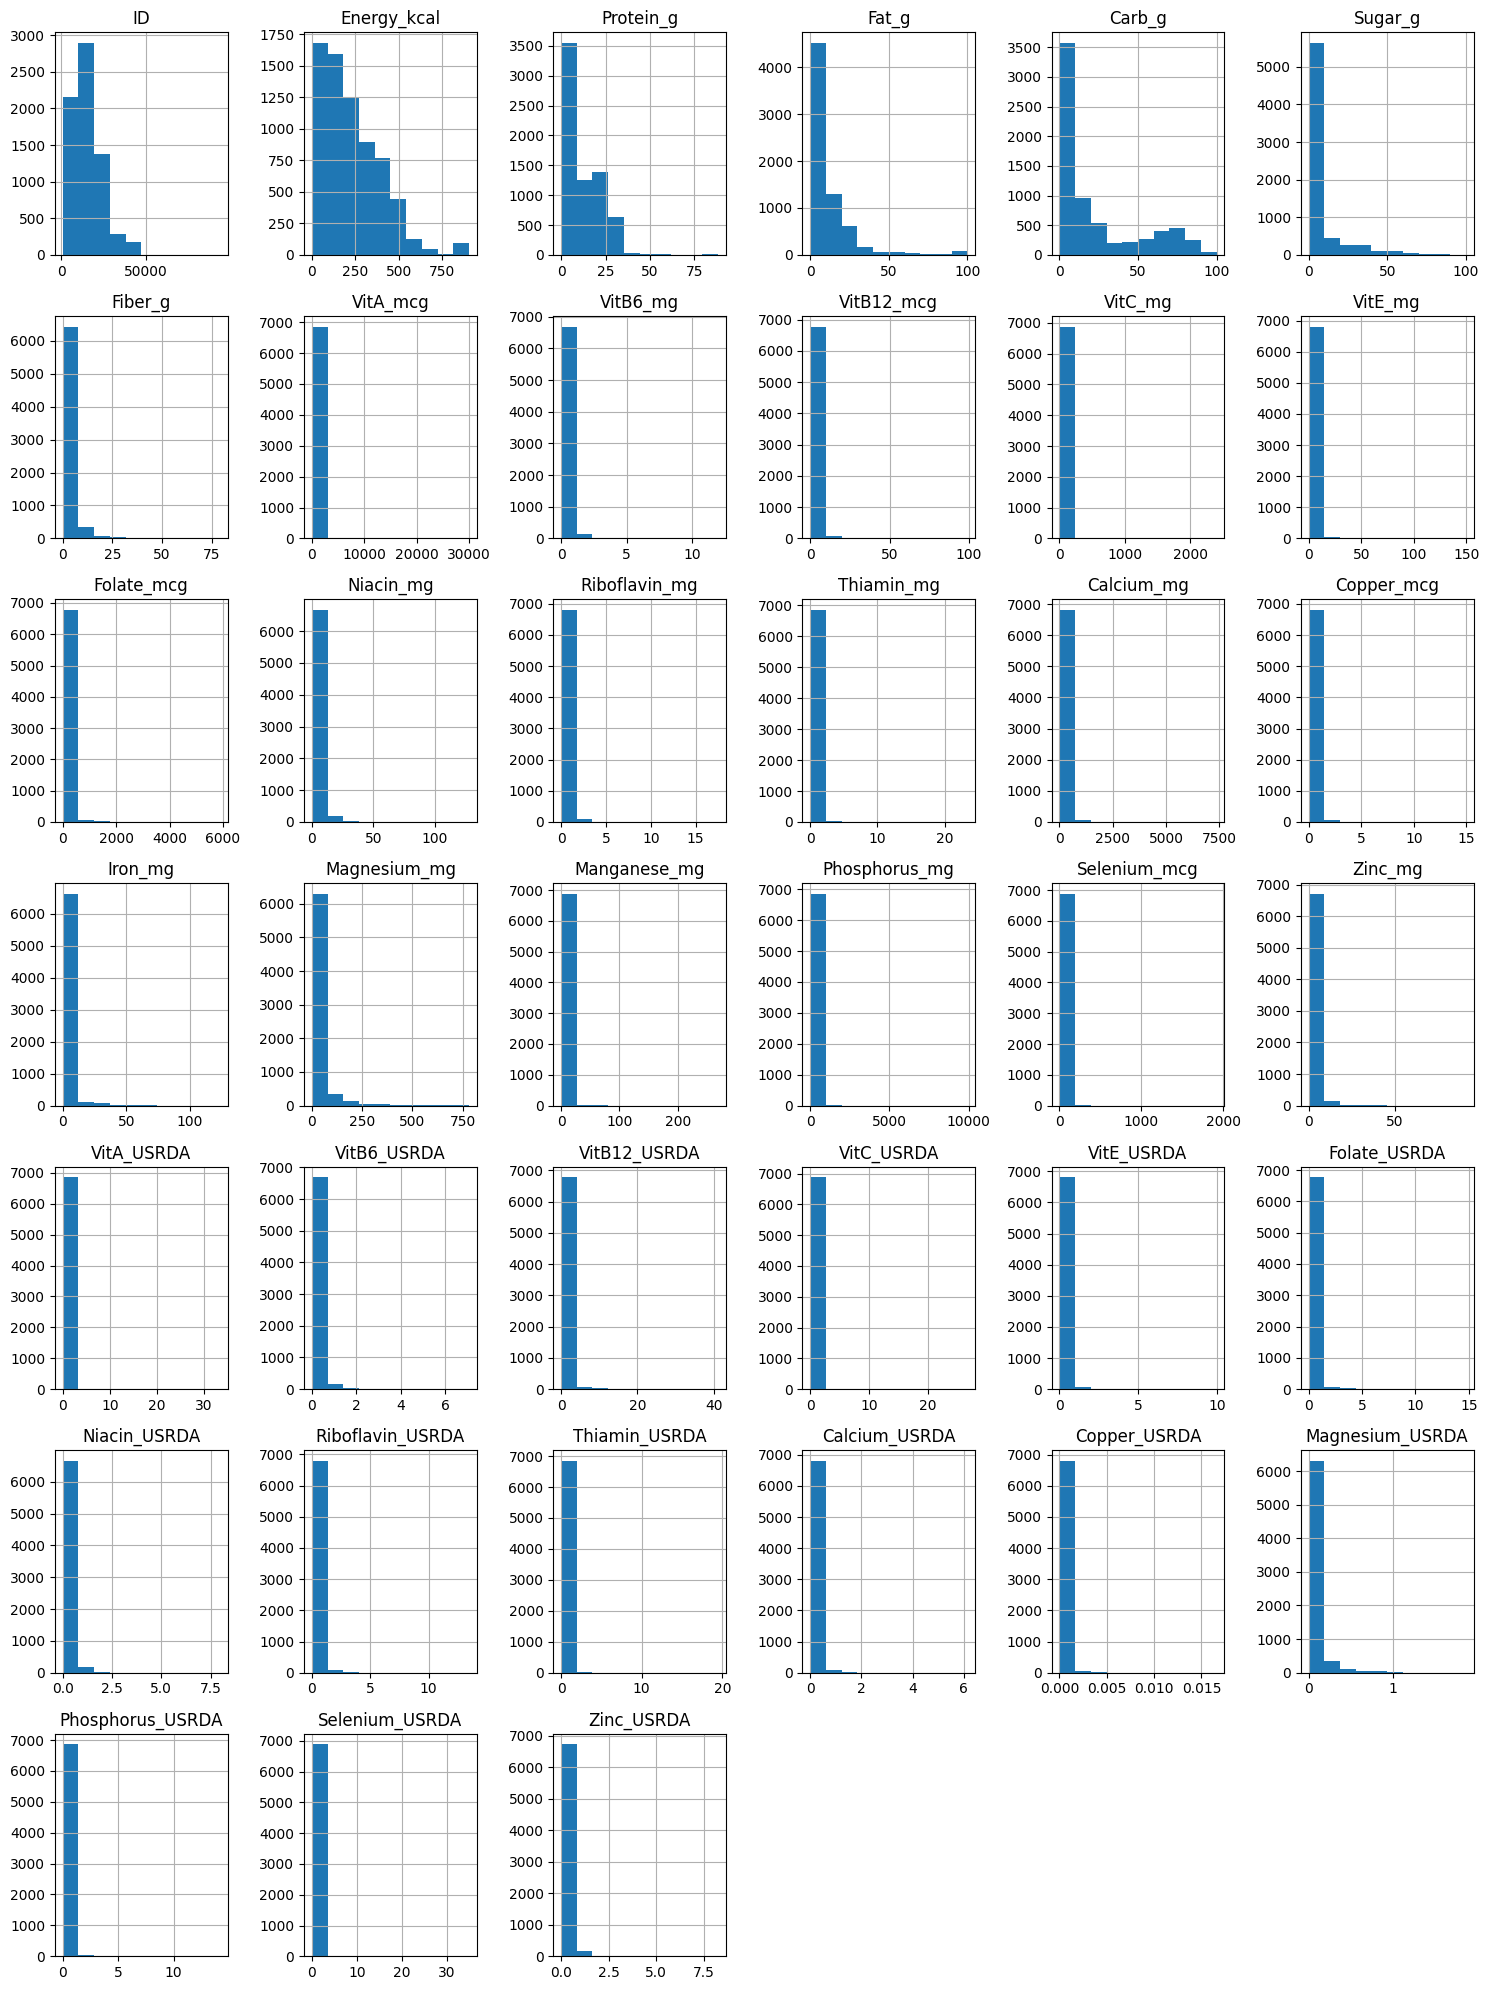

In [15]:
train_rg.hist(figsize=(15,20))
plt.tight_layout();

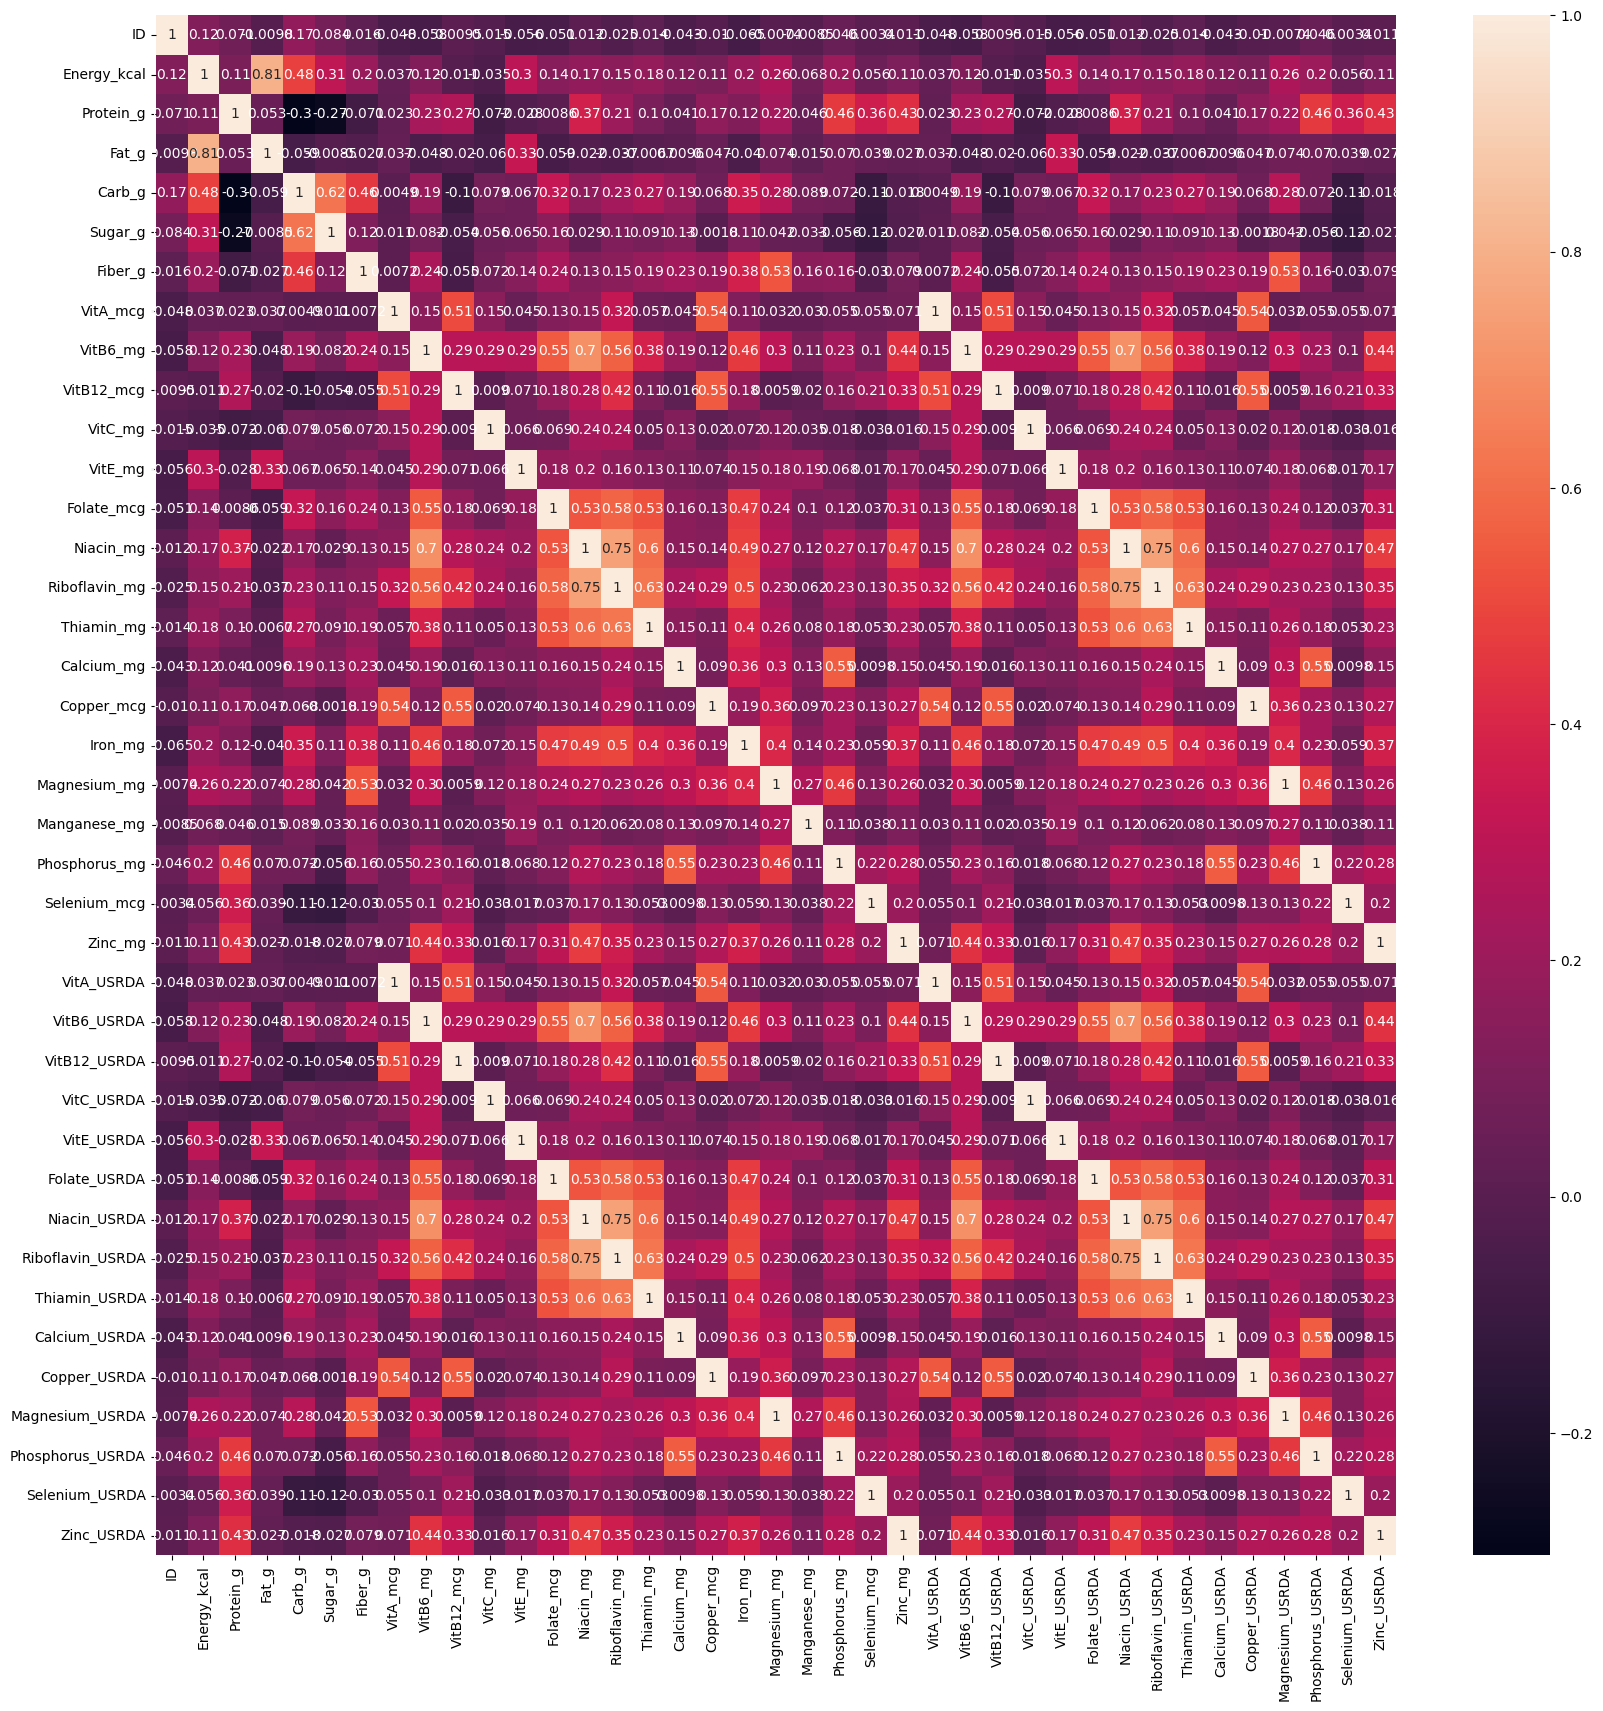

In [16]:
plt.figure(figsize= (20, 20))
sns.heatmap(train_rg.corr(numeric_only= True), annot= True);

Observamos varios puntos a tratar:
- `ID` es una columa con alta cardinalidad, por tanto quedará excluida
- Todas las variables numéricas necesitan una transformación logarítmica.
- Las variables `USRDA` presentan una alta correlación con su pareja en g/mg/mcg. Las excluremos para evitar la multicolinealidad.
- Aplicaremos un StandardScaler ya que nuestros datos están en diferentes escalas (kcal, g, mg, mcg)
- Como reducción y selección de features, aplicaremos una PCA

In [8]:
# Lista de variables numericas que se exluyen
num_columns_to_exclude = [col for col in var_num if col == 'ID' or col.endswith('USRDA')]
num_columns_to_exclude

['ID',
 'VitA_USRDA',
 'VitB6_USRDA',
 'VitB12_USRDA',
 'VitC_USRDA',
 'VitE_USRDA',
 'Folate_USRDA',
 'Niacin_USRDA',
 'Riboflavin_USRDA',
 'Thiamin_USRDA',
 'Calcium_USRDA',
 'Copper_USRDA',
 'Magnesium_USRDA',
 'Phosphorus_USRDA',
 'Selenium_USRDA',
 'Zinc_USRDA']

In [9]:
# Lista de variables numericas para tranformar
num_transform = [col for col in var_num if col not in num_columns_to_exclude]
num_transform

['Protein_g',
 'Fat_g',
 'Carb_g',
 'Sugar_g',
 'Fiber_g',
 'VitA_mcg',
 'VitB6_mg',
 'VitB12_mcg',
 'VitC_mg',
 'VitE_mg',
 'Folate_mcg',
 'Niacin_mg',
 'Riboflavin_mg',
 'Thiamin_mg',
 'Calcium_mg',
 'Copper_mcg',
 'Iron_mg',
 'Magnesium_mg',
 'Manganese_mg',
 'Phosphorus_mg',
 'Selenium_mcg',
 'Zinc_mg']

Por lo tanto, unimos todas las variables que vamos a excluir en una única lista

In [10]:
excluded_cols = num_columns_to_exclude + cat_columns_to_exclude
excluded_cols

['ID',
 'VitA_USRDA',
 'VitB6_USRDA',
 'VitB12_USRDA',
 'VitC_USRDA',
 'VitE_USRDA',
 'Folate_USRDA',
 'Niacin_USRDA',
 'Riboflavin_USRDA',
 'Thiamin_USRDA',
 'Calcium_USRDA',
 'Copper_USRDA',
 'Magnesium_USRDA',
 'Phosphorus_USRDA',
 'Selenium_USRDA',
 'Zinc_USRDA',
 'ShortDescrip',
 'Descrip',
 'CommonName',
 'MfgName',
 'ScientificName']

### Creación de las parejas X,y

In [11]:
# Para hacer el pipeline
X_train = train_rg.drop(train_rg[[target]], axis=1)
X_test = test_rg.drop(test_rg[[target]], axis=1)

y_train = train_rg[target]
y_test = test_rg[target]

## Pipeline

### Transformación de las **Features**

In [12]:
num_pipeline = Pipeline([
    ('log', FunctionTransformer(np.log1p, feature_names_out='one-to-one')), # Este último argumento para poder generar el DataFrame posterior
    ('SScaler', StandardScaler())
])

# Pipeline para características categóricas
cat_pipeline = Pipeline([
    ('OHEncoder', OneHotEncoder())
])

# Transformador de columnas
prepocessing = ColumnTransformer([
        ('Impute_Numeric', num_pipeline, num_transform),
        ('Process_Categorical', cat_pipeline, cat_transform),
        ('Exclude', 'drop', excluded_cols)
    ],
    remainder='passthrough'
)

In [15]:
prepocessing

ColumnTransformer(remainder='passthrough',
                  transformers=[('Impute_Numeric',
                                 Pipeline(steps=[('log',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'log1p'>)),
                                                 ('SScaler',
                                                  StandardScaler())]),
                                 ['Protein_g', 'Fat_g', 'Carb_g', 'Sugar_g',
                                  'Fiber_g', 'VitA_mcg', 'VitB6_mg',
                                  'VitB12_mcg', 'VitC_mg', 'VitE_mg',
                                  'Folate_mcg', 'Niacin_mg', 'Riboflavin_mg',
                                  'Th...
                                                  OneHotEncoder())]),
                                 ['FoodGroup']),
                                ('Exclude', 'drop',
                                 ['ID', 'VitA_USRDA', 'VitB6_USRDA',
                                  'VitB12_USRDA', 'VitC_USRDA', 'VitE_USRDA',
                                  'Folate_USRDA', 'Niacin_USRDA',
                                  'Riboflavin_USRDA', 'Thiamin_USRDA',
                                  'Calcium_USRDA', 'Copper_USRDA',
                                  'Magnesium_USRDA', 'Phosphorus_USRDA',
                                  'Selenium_USRDA', 'Zinc_USRDA',
                                  'ShortDescrip', 'Descrip', 'CommonName',
                                  'MfgName', 'ScientificName'])])

In [13]:
X_train_pipe = prepocessing.fit_transform(X_train)

In [14]:
# Visualizamos el preprocesado en un DataFrame
X_train_pipe_df = pd.DataFrame(X_train_pipe, columns=prepocessing.get_feature_names_out())
X_train_pipe_df.head()

,Impute_Numeric__Protein_g,Impute_Numeric__Fat_g,Impute_Numeric__Carb_g,Impute_Numeric__Sugar_g,Impute_Numeric__Fiber_g,Impute_Numeric__VitA_mcg,Impute_Numeric__VitB6_mg,Impute_Numeric__VitB12_mcg,Impute_Numeric__VitC_mg,Impute_Numeric__VitE_mg,...,Process_Categorical__FoodGroup_Nut and Seed Products,Process_Categorical__FoodGroup_Pork Products,Process_Categorical__FoodGroup_Poultry Products,Process_Categorical__FoodGroup_Restaurant Foods,Process_Categorical__FoodGroup_Sausages and Luncheon Meats,Process_Categorical__FoodGroup_Snacks,"Process_Categorical__FoodGroup_Soups, Sauces, and Gravies",Process_Categorical__FoodGroup_Spices and Herbs,Process_Categorical__FoodGroup_Sweets,Process_Categorical__FoodGroup_Vegetables and Vegetable Products
0,1.127509,0.775239,-1.305832,-0.794059,-0.813082,-0.831996,-0.320732,1.256975,-0.636203,-0.567323,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.805595,-1.172554,0.560213,-0.794059,0.518713,-0.831996,-0.605178,-0.698625,1.099940,-0.567323,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-1.291394,0.704356,-0.054053,0.505347,0.435076,1.574257,0.458770,-0.698625,3.372347,1.973866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.911472,-0.093717,1.192471,-0.794059,2.436992,1.939552,3.302225,-0.698625,2.454994,-0.567323,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.890488,0.908655,-0.093692,-0.178331,1.088476,-0.831996,0.852421,1.120196,-0.636203,-0.567323,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
X_train_pipe_df.isnull().sum()

Impute_Numeric__Protein_g                                             0
Impute_Numeric__Fat_g                                                 0
Impute_Numeric__Carb_g                                                0
Impute_Numeric__Sugar_g                                               0
Impute_Numeric__Fiber_g                                               0
Impute_Numeric__VitA_mcg                                              0
Impute_Numeric__VitB6_mg                                              0
Impute_Numeric__VitB12_mcg                                            0
Impute_Numeric__VitC_mg                                               0
Impute_Numeric__VitE_mg                                               0
Impute_Numeric__Folate_mcg                                            0
Impute_Numeric__Niacin_mg                                             0
Impute_Numeric__Riboflavin_mg                                         0
Impute_Numeric__Thiamin_mg                                      

In [25]:
# Dimensiones para elegir el maximo de componentes en PCA
X_train_pipe_df.shape

(6894, 47)

## Entrenamiento 

Elegimos para entrenar modelos lineales como **Regresión Lineal**, ensamblados como **Random Forest** y boosting como **XGBoost** y **LightGBM**

Además, usaremos un estimador no supervisado como **PCA** para hacer una reducción de features y conseguir así una mejor métrica.

En primer lugar, instanciaremos los modelos con ayuda de **Pipelines** y haremos un *baseline* con **Cross Validation** para tomar como referencia esas métricas.

In [23]:
linear_pipe = Pipeline(
    [('Preprocesado', prepocessing),
     ('Modelo', LinearRegression())
     ])

random_pipe = Pipeline(
    [('Preprocesado', prepocessing),
     ('Modelo', RandomForestRegressor())
     ])

xgb_pipe = Pipeline(
    [('Preprocesado', prepocessing),
     ('Modelo', XGBRegressor())
     ])

lgb_pipe = Pipeline([
    ('Preprocesado', prepocessing),
    ('Modelo', LGBMRegressor())
    ])

# Aplico la transformacion logaritmica del Target con TransformedTargetRegressor()
for name,pipe in zip(['LinealRegresor', 'RandomF', 'XGB', 'LGB'], [linear_pipe, random_pipe, xgb_pipe, lgb_pipe]):
    tt = TransformedTargetRegressor(regressor=pipe, func=np.log1p, inverse_func=np.exp)
    cross_val = np.mean(cross_val_score(tt, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    print(f'{name} --> {-(cross_val):.4f}')

LinealRegresor --> 10181.9525
RandomF --> 301.6039
XGB --> 362.9729
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000000
[LightGBM] [Debug] init for col-wise cost 0.000003 seconds, init for row-wise cost 0.000519 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5555
[LightGBM] [Info] Number of data points in the train set: 6204, number of used features: 47
[LightGBM] [Info] Start training from score 5.080732
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Train

In [ ]:
# Añado los resultados en un diccionario (Para no ejecutar de nuevo todo)
resultados = {
    'Baseline': [('Regresion Lineal', 10181.9525),
                 ('RandomForest', 301.6039),
                 ('XGB', 362.9729),
                 ('LGB', 335.8845)]
}

In [31]:
resultados

{'Baseline': [('Regresion Lineal', 32.86),
  ('RandomForest', 7.58),
  ('XGB', 8.06),
  ('LGB', 8.8)]}

Con ayuda de `TransformedTargetRegressor()`, el mejor error es la obtenida con **Random Forest** por lo que optimizo sus hiperparámetros.

Además de añadir el `TransformedTargetRegressor()` y optimizar los hiperparámetros, aplicaremos la **PCA** para mejorar el modelo.

### Búsqueda del mejor compenente para la PCA

Dado que tenemos 47 features en total, utilizaremos una PCA para reducir la dimensionalidad del set.  
Antes de integrarla en un pipeline, determinaremos cuál es el número de componentes óptimos para alcanzar al menos el 90% de la varianza acumulada.

In [25]:
#Para no transformar los datos de train al buscar el número optimo de componentes principales, haremos una copia del dataset transformado para hacer las comprobaciones
X_train_pipe_df_copy = X_train_pipe_df.copy()

In [26]:
pca = PCA()
X_train_ncomp_pca = pca.fit(X_train_pipe_df_copy) #aplicamos la transformacion a todo el dataset

varizanza_acumulada = pca.explained_variance_ratio_.cumsum()
varizanza_acumulada #vemos el total de porcentaje de varianza acumulada por componente

array([0.30495559, 0.47579563, 0.54808615, 0.61539303, 0.67057802,
       0.71521735, 0.7456646 , 0.77343182, 0.79918432, 0.82137508,
       0.84246696, 0.8622942 , 0.88002369, 0.89436303, 0.9081559 ,
       0.92109925, 0.93239615, 0.94213493, 0.95092519, 0.95811526,
       0.96489494, 0.9702561 , 0.97336411, 0.97597199, 0.97837164,
       0.9803524 , 0.9821152 , 0.98384444, 0.98549271, 0.98695977,
       0.98835705, 0.98973509, 0.99103626, 0.99217574, 0.99328212,
       0.99420748, 0.99507937, 0.99588885, 0.99663839, 0.99736318,
       0.99797344, 0.99849565, 0.99900635, 0.99947855, 0.99978921,
       1.        , 1.        ])

En este caso marcaremos un 98% de umbral, esto quiere decir que nos quedaremos con el número de features que expliquen la varianza acumulada del 98%. (Dependiendo de los resultados del modelo podremos subir o bajar el umbral)

In [ ]:
umbral = len(varizanza_acumulada[varizanza_acumulada >= 0.98]) #seleccionamos las componentes que acumulan el 98% de varianza 
n_componentes_98 = X_train_pipe_df_copy.shape[1] - umbral + 1 #Accedemos a las columnas del set de train y restamos el número de componentes que exceden el umbral marcado
                                                            #sumamos 1 porque el indice de columnas comienza en 0 y de esta forma nos dará el número exacto contando desde 1
print(f'Componentes que exceden el 98%: {umbral}')
print(f'El numero de componentes necesarias para alcanzar el {round(varizanza_acumulada[23],2)} es {n_componentes_98}') #Pongo 23 como indice aunque el numero de componentes sea 22 porque en el array empiezo contando desde 0

Componentes que exceden el 98%: 22
El numero de componentes necesarias para alcanzar el 0.98 es 26


In [31]:
# He instanciado de nuevo el Pipeline de RandomForest sin el preprocesado porque me daba error y lo he instanciado en el pipeline_grid
# Lo mismo con instanciar con una variable el modelo y despues darsela como argumento en regressor dentro de la funcion TransfomerTarget valdría
random_pipe = Pipeline(
    [('Modelo', RandomForestRegressor())
     ])

pipeline_grid = Pipeline([
    ('preprocesado', prepocessing),
    ('pca', PCA(n_components=26)),
    ('model', TransformedTargetRegressor(regressor=random_pipe, func=np.log1p, inverse_func=np.exp))])

In [33]:
'''
En params_grid llamo al Random Forest "model__regressor__Modelo__. Explico:
- model__ porque esta dentro de pipeline_grid
- regressor__ porque esta dentro del argumento 'regressor' de la funcion TransformerTargetRegressor()
- Modelo__ porque dentro de ese argumento llamo a random_pipe, y el modelo esta instanciado en 'Modelo'
'''

params_grid = {
    'model__regressor__Modelo__n_estimators': [100,200],
    'model__regressor__Modelo__max_depth': [None, 10,20],
    'model__regressor__Modelo__max_features': [None, 'sqrt', 'log2'],
    'model__regressor__Modelo__min_samples_split': [2,5],
    'model__regressor__Modelo__min_samples_leaf': [1,2,5]
}

grid = GridSearchCV(pipeline_grid, params_grid, cv=5, scoring='neg_mean_squared_error')

grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocesado',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('Impute_Numeric',
                                                                         Pipeline(steps=[('log',
                                                                                          FunctionTransformer(feature_names_out='one-to-one',
                                                                                                              func=<ufunc 'log1p'>)),
                                                                                         ('SScaler',
                                                                                          StandardScaler())]),
                                                                         ['Protein_g',
                                                                          'Fat_g',
                                                                          'Carb_g',
                                                                          'Sugar_g',
                                                                          'Fiber_g',
                                                                          'VitA_mcg',
                                                                          'VitB6_mg',
                                                                          'VitB12_mcg',
                                                                          'Vit...
                                                                   regressor=Pipeline(steps=[('Modelo',
                                                                                              RandomForestRegressor())])))]),
             param_grid={'model__regressor__Modelo__max_depth': [None, 10, 20],
                         'model__regressor__Modelo__max_features': [None,
                                                                    'sqrt',
                                                                    'log2'],
                         'model__regressor__Modelo__min_samples_leaf': [1, 2,
                                                                        5],
                         'model__regressor__Modelo__min_samples_split': [2, 5],
                         'model__regressor__Modelo__n_estimators': [100, 200]},
             scoring='neg_mean_squared_error')

In [36]:
print('Mejores parámetros -->', grid.best_params_)
print('Mejor score -->', np.sqrt(-grid.best_score_))

Mejores parámetros --> {'model__regressor__Modelo__max_depth': None, 'model__regressor__Modelo__max_features': None, 'model__regressor__Modelo__min_samples_leaf': 1, 'model__regressor__Modelo__min_samples_split': 2, 'model__regressor__Modelo__n_estimators': 200}
Mejor score --> 51.84260260075709


In [39]:
# Evaluamos contra test
y_pred = grid.predict(X_test)

root_score = root_mean_squared_error(y_test, y_pred)

score_test= np.sqrt(root_score)

print('Test score -->', score_test)


Test score --> 6.953067317211295


In [42]:
with open('modelo_regresion_pipeline.pkl', 'wb') as archivo:
    pickle.dump(grid, archivo)

Probamos con cambiar la métrica y en vez de usar **MSE**, vamos a probar **MAE** ya que es más robusto para los outliers.

In [16]:
linear_pipe = Pipeline(
    [('Preprocesado', prepocessing),
     ('Modelo', LinearRegression())
     ])

random_pipe = Pipeline(
    [('Preprocesado', prepocessing),
     ('Modelo', RandomForestRegressor())
     ])

xgb_pipe = Pipeline(
    [('Preprocesado', prepocessing),
     ('Modelo', XGBRegressor())
     ])

lgb_pipe = Pipeline([
    ('Preprocesado', prepocessing),
    ('Modelo', LGBMRegressor())
    ])

# Aplico la transformacion logaritmica del Target con TransformedTargetRegressor()
for name,pipe in zip(['LinealRegresor', 'RandomF', 'XGB', 'LGB'], [linear_pipe, random_pipe, xgb_pipe, lgb_pipe]):
    tt = TransformedTargetRegressor(regressor=pipe, func=np.log1p, inverse_func=np.exp)
    cross_val = np.mean(cross_val_score(tt, X_train, y_train, cv=10, scoring='neg_mean_absolute_error'))
    print(f'{name} --> {-(cross_val):.4f}')

LinealRegresor --> 50.9371
RandomF --> 7.5713
XGB --> 8.0685
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5555
[LightGBM] [Info] Number of data points in the train set: 6204, number of used features: 47
[LightGBM] [Info] Start training from score 5.080732
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5558
[LightGBM] [Info] Number of data points in the train set: 6204, number of used features: 47
[LightGBM] [Info] Start training from score 5.082710
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55

In [18]:
random_pipe = Pipeline(
    [('Modelo', RandomForestRegressor())
     ])

pipeline_grid = Pipeline([
    ('preprocesado', prepocessing),
    ('pca', PCA(n_components=26)),
    ('model', TransformedTargetRegressor(regressor=random_pipe, func=np.log1p, inverse_func=np.exp))])

In [19]:
params_grid = {
    'model__regressor__Modelo__n_estimators': [100,200],
    'model__regressor__Modelo__max_depth': [None, 10,20],
    'model__regressor__Modelo__max_features': [None, 'sqrt', 'log2'],
    'model__regressor__Modelo__min_samples_split': [2,5],
    'model__regressor__Modelo__min_samples_leaf': [1,2,5]
}

grid = GridSearchCV(pipeline_grid, params_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocesado',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('Impute_Numeric',
                                                                         Pipeline(steps=[('log',
                                                                                          FunctionTransformer(feature_names_out='one-to-one',
                                                                                                              func=<ufunc 'log1p'>)),
                                                                                         ('SScaler',
                                                                                          StandardScaler())]),
                                                                         ['Protein_g',
                                                                          'Fat_g',
                                                                          'Carb_g',
                                                                          'Sugar_g',
                                                                          'Fiber_g',
                                                                          'VitA_mcg',
                                                                          'VitB6_mg',
                                                                          'VitB12_mcg',
                                                                          'Vit...
                                                                                              RandomForestRegressor())])))]),
             n_jobs=-1,
             param_grid={'model__regressor__Modelo__max_depth': [None, 10, 20],
                         'model__regressor__Modelo__max_features': [None,
                                                                    'sqrt',
                                                                    'log2'],
                         'model__regressor__Modelo__min_samples_leaf': [1, 2,
                                                                        5],
                         'model__regressor__Modelo__min_samples_split': [2, 5],
                         'model__regressor__Modelo__n_estimators': [100, 200]},
             scoring='neg_mean_absolute_error')

In [23]:
print('Mejores parámetros -->', grid.best_params_)
print('Mejor score -->',(-grid.best_score_))

Mejores parámetros --> {'model__regressor__Modelo__max_depth': None, 'model__regressor__Modelo__max_features': None, 'model__regressor__Modelo__min_samples_leaf': 1, 'model__regressor__Modelo__min_samples_split': 2, 'model__regressor__Modelo__n_estimators': 200}
Mejor score --> 28.51663387009848


In [25]:
# Evaluamos contra test
y_pred = grid.predict(X_test)

mae_score = mean_absolute_error(y_test, y_pred)

print('Test score -->', mae_score)

Test score --> 26.580626544912434
